In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.051 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 40
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

200000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

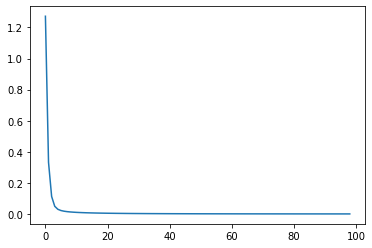

In [8]:
plt.plot(S)

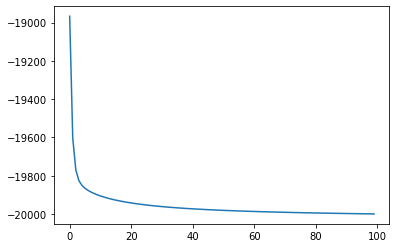

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.000440404367451265

In [11]:
eta

array([-18967.12166885, -19603.1331866 , -19769.26468494, -19825.65165991,
       -19850.38997577, -19865.52561768, -19876.64938756, -19885.58872014,
       -19893.1300091 , -19899.68102179, -19905.48191982, -19910.68768811,
       -19915.40540118, -19919.71300086, -19923.66958399, -19927.32142839,
       -19930.70572155, -19933.85297661, -19936.78866044, -19939.53432859,
       -19942.10844021, -19944.5269585 , -19946.80380339, -19948.95119964,
       -19950.97994945, -19952.89964918, -19954.71886422, -19956.44527167,
       -19958.08577825, -19959.64661847, -19961.13343721, -19962.55135979,
       -19963.90505164, -19965.19876962, -19966.43640632, -19967.62152853,
       -19968.75741075, -19969.84706459, -19970.89326457, -19971.89857092,
       -19972.86534977, -19973.79579099, -19974.69192424, -19975.55563309,
       -19976.38866788, -19977.19265705, -19977.9691175 , -19978.71946376,
       -19979.44501642, -19980.14700965, -19980.82659803, -19981.48486278,
       -19982.1228174 , -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.03227833e+03, 3.96266816e+02, 2.30135317e+02, 1.73748342e+02,
       1.49010026e+02, 1.33874385e+02, 1.22750615e+02, 1.13811282e+02,
       1.06269993e+02, 9.97189804e+01, 9.39180824e+01, 8.87123141e+01,
       8.39946011e+01, 7.96870014e+01, 7.57304182e+01, 7.20785738e+01,
       6.86942807e+01, 6.55470256e+01, 6.26113418e+01, 5.98656736e+01,
       5.72915620e+01, 5.48730437e+01, 5.25961989e+01, 5.04488026e+01,
       4.84200528e+01, 4.65003531e+01, 4.46811380e+01, 4.29547306e+01,
       4.13142240e+01, 3.97533838e+01, 3.82665650e+01, 3.68486424e+01,
       3.54949506e+01, 3.42012326e+01, 3.29635959e+01, 3.17784737e+01,
       3.06425915e+01, 2.95529377e+01, 2.85067377e+01, 2.75014313e+01,
       2.65346525e+01, 2.56042112e+01, 2.47080780e+01, 2.38443691e+01,
       2.30113344e+01, 2.22073452e+01, 2.14308847e+01, 2.06805385e+01,
       1.99549858e+01, 1.92529926e+01, 1.85734042e+01, 1.79151395e+01,
       1.72771848e+01, 1.66585894e+01, 1.60584603e+01, 1.54759580e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_11.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_11.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_11.csv', S, delimiter = ',')